
# 1. Introduction

This notebook aims to predict customer churn using machine learning techniques. We'll explore the dataset, preprocess the data, select features, and evaluate various models to find the best approach for predicting churn.

Dataset: Customer data with various features related to their energy consumption and account details.

Target: Predict whether a customer will churn (1) or not (0).

# 2. Data Loading and Exploration

## Import Packages

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning preprocessing and model selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold



# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, space_eval, Trials
from sklearn.utils.class_weight import compute_class_weight

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, roc_curve
)

# Visualization settings
plt.style.use('bmh')
sns.set_theme(style="whitegrid")

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
df = pd.read_csv('data/data_for_predictions.csv', index_col=0)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14606 entries, 0 to 14605
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          14606 non-null  object 
 1   cons_12m                                    14606 non-null  float64
 2   cons_gas_12m                                14606 non-null  float64
 3   cons_last_month                             14606 non-null  float64
 4   forecast_cons_12m                           14606 non-null  float64
 5   forecast_discount_energy                    14606 non-null  float64
 6   forecast_meter_rent_12m                     14606 non-null  float64
 7   forecast_price_energy_off_peak              14606 non-null  float64
 8   forecast_price_energy_peak                  14606 non-null  float64
 9   forecast_price_pow_off_peak                 14606 non-null  float64
 10  has_gas        


# 3. Data Preprocessing

## Data Splitting

In [3]:
# Separate features and target
X = df.drop(['churn', 'id'], axis=1)
y = df['churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
740,3.803457,0.0,2.257679,2.535446,0.0,0.000000,0.144038,0.000000,46.311378,0,...,2,0,0,0,1,0,0,0,0,1
3468,4.334816,0.0,3.492900,3.369989,0.0,2.119487,0.117486,0.100597,40.606701,0,...,7,0,0,0,0,0,1,0,0,1
14013,4.696819,0.0,0.000000,3.399601,0.0,1.213518,0.144058,0.000000,44.311378,0,...,4,2,0,0,1,0,0,0,0,1
1188,4.660030,0.0,3.558948,3.280785,0.0,1.402089,0.161743,0.083849,44.311378,0,...,32,8,0,0,1,0,0,0,0,1
13098,4.073938,0.0,3.067071,3.041795,0.0,2.167819,0.115172,0.098283,40.606701,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,4.579921,0.0,0.000000,3.065617,0.0,2.085540,0.114603,0.098261,40.606701,0,...,6,5,0,0,0,0,1,1,0,0
13418,4.206367,0.0,3.043362,3.234583,0.0,2.183042,0.113437,0.096547,40.606701,0,...,0,11,1,0,0,0,0,0,1,0
5390,4.154637,0.0,3.038223,3.133794,0.0,2.121855,0.115237,0.100123,40.606701,0,...,76,1,1,0,0,0,0,1,0,0
860,6.612824,0.0,5.646696,2.836134,0.0,1.249443,0.144902,0.000000,44.311378,0,...,2,6,0,0,1,0,0,0,0,1


In [43]:
X_train['cons_gas_12m'].nunique()

1701

## Feature Scaling and Imputation

In [27]:
def create_preprocessing_pipeline(numeric_features, impute_strategy='mean', scale=True):
    """
    Creates a preprocessing pipeline for numeric features.

    Parameters:
    - numeric_features (list): List of numeric feature names.
    - impute_strategy (str, optional): Strategy for imputation ('mean', 'median', etc.).
    - scale (bool, optional): Whether to include scaling in the pipeline.

    Returns:
    - preprocessor (ColumnTransformer): Preprocessing pipeline.
    """
    steps = []
    
    # Imputation
    steps.append(('imputer', SimpleImputer(strategy=impute_strategy)))
    
    # Scaling
    if scale:
        steps.append(('scaler', StandardScaler()))
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps), numeric_features)
        ],
        remainder='passthrough'
    )
    preprocessor.set_output(transform="pandas")  # This ensures DataFrame output
    
    return preprocessor

In [28]:
# Identify numeric features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing pipeline
preprocessor = create_preprocessing_pipeline(numeric_features)

# Fit and transform the training data, transform the test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [24]:
print(f"Training set size: {X_train_preprocessed.shape[0]} samples")
print(f"Test set size: {X_test_preprocessed.shape[0]} samples")

# Check class distribution
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 11684 samples
Test set size: 2922 samples
Training set class distribution:
churn
0    0.904656
1    0.095344
Name: proportion, dtype: float64

Test set class distribution:
churn
0    0.895619
1    0.104381
Name: proportion, dtype: float64



# 4. Model Selection and Initial Evaluation

## Model Selection

The following models were trained and evaluated:
- Logistic Regression
- Decision Tree
- Random Forest
- eXtreme Gradient Boosting (XGBoost)

Key Performance Metrics:

To assess the effectiveness of each model, we employed several performance metrics:
- **Accuracy**: The proportion of correct predictions (both churn and non-churn) out of all predictions made.
- **Precision**: The ability of the model to correctly identify true churn cases out of all predicted churns.
- **Recall (Sensitivity)**: The ability of the model to correctly identify true churn cases out of all actual churns.
- **F1-Score**: The harmonic mean of Precision and Recall, providing a balance between the two.
- **ROC AUC**: Measures the model's ability to distinguish between classes across all thresholds.

Given the class imbalance in our dataset (2,617 non-churn vs. 305 churn cases), certain metrics like Accuracy can be misleading. 
Therefore, emphasis is placed on Precision, Recall, and ROC AUC to better understand the models' effectiveness in identifying churn cases.

In [7]:
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, cv=5):
    """
    Trains and evaluates multiple models, returning their performance metrics.

    Parameters:
    - models (dict): Dictionary of model names and instances.
    - X_train (array-like): Training features.
    - y_train (array-like): Training target.
    - X_test (array-like): Testing features.
    - y_test (array-like): Testing target.
    - cv (int): Number of cross-validation folds.

    Returns:
    - results_df (DataFrame): DataFrame containing performance metrics for each model.
    """
    results = {}
    
    for name, model in models.items():
        print(f"Training and evaluating {name}...")
        
        # Cross-validation on training set
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        cv_score_mean = np.mean(cv_scores)
        
        # Fit the model on the training set
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
        
        # Store results
        results[name] = {
            'CV ROC AUC': cv_score_mean,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'ROC AUC': roc_auc
        }
        
        # Display classification report
        print(f"Classification Report for {name}:\n")
        print(classification_report(y_test, y_pred, zero_division=0))
        print("-" * 50)
    
    results_df = pd.DataFrame(results).T
    return results_df

In [8]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Train and evaluate models
results_df = train_and_evaluate_models(
    models,
    X_train_preprocessed,
    y_train,
    X_test_preprocessed,
    y_test,
    cv=5
)

print("Model Performance Metrics:")
results_df


Training and evaluating Logistic Regression...
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2617
           1       0.75      0.01      0.02       305

    accuracy                           0.90      2922
   macro avg       0.82      0.50      0.48      2922
weighted avg       0.88      0.90      0.85      2922

--------------------------------------------------
Training and evaluating Decision Tree...
Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2617
           1       0.21      0.24      0.23       305

    accuracy                           0.83      2922
   macro avg       0.56      0.57      0.57      2922
weighted avg       0.84      0.83      0.83      2922

--------------------------------------------------
Training and evaluating Random Forest...
Classification Report for

,CV ROC AUC,Accuracy,Precision,Recall,F1-score,ROC AUC
Logistic Regression,0.649656,0.896304,0.750000,0.009836,0.019417,0.609142
Decision Tree,0.562894,0.829227,0.214706,0.239344,0.226357,0.568660
Random Forest,0.680633,0.899726,0.772727,0.055738,0.103976,0.656903
XGBoost,0.694447,0.904175,0.681159,0.154098,0.251337,0.678215


**Interpretation of Results:**

1. **Logistic Regression:**
   - High accuracy (90%) but extremely low Recall (1%) for churn cases, indicating that it fails to identify the majority of at-risk customers.
   - Strong Precision (75%) when predicting churn, meaning that when the model does predict churn, it is often correct.
   - However, the model struggles with Recall, leading to 99% false negatives, which means most customers likely to churn are not flagged.
   - Given the project’s focus on reducing churn, this model is not effective for identifying at-risk customers, despite its overall accuracy.

2. **Decision Tree:**
   - Lower accuracy (83%) but improved Recall (24%) compared to Logistic Regression, allowing for better identification of at-risk customers.
   - Precision remains low (21%), resulting in a higher false positive rate, meaning many customers are incorrectly flagged as at risk.
   - While this model is better at identifying churn cases, the trade-off in false positives may result in unnecessary interventions for customers not actually at risk of leaving.
   - Its balance between Recall and Precision is not optimal for the project's goal of identifying price-sensitive customers who are most likely to churn.

3. **Random Forest:**
   - Highest accuracy (90%) and best Precision (77%) for predicting churn, meaning fewer false positives.
   - However, it has a very low Recall (6%), missing 94% of actual churn cases, making it unsuitable for identifying the majority of at-risk customers.
   - Although the model performs well when it does predict churn, it rarely flags customers at risk, limiting its usefulness in reducing churn rates driven by price sensitivity.

4. **XGBoost:**
   - Provides a more balanced approach with high accuracy (90%) and the highest ROC AUC (68%).
   - Moderate improvement in Recall (15%) compared to the other models, allowing it to identify more at-risk customers, though it still misses 85% of actual churn cases.
   - Precision (68%) is reasonable, and its F1-score (25%) indicates a better balance between Precision and Recall compared to other models.
   - XGBoost shows the most promise for identifying price-sensitive customers at risk of churn, though improvements in Recall are still necessary to better capture the full spectrum of at-risk customers.

**Key Insight**
- **High Accuracy is Misleading**: All models—particularly Logistic Regression, Random Forest, and XGBoost—report high accuracy scores around 90%. However, this accuracy is deceptive due to the class imbalance, where the majority class (non-churn) dominates the predictions. The high accuracy inflates the perception of model performance, masking the fact that churn cases (the minority class) are not being well-detected, which is critical for PowerCo's goal of reducing churn.

**Conclusion:**  
> The current models demonstrate high accuracy, but this is misleading due to the class imbalance, where the majority of predictions are skewed towards non-churn customers. The primary goal of this project is to help PowerCo reduce churn by identifying at-risk customers, particularly those sensitive to price changes. However, the low Recall across all models highlights a significant challenge: most churn cases are being missed.
>
> Among the models tested, XGBoost offers the most promise, with a higher ROC AUC (68%) and a better balance between Precision and Recall compared to the other models. It shows potential for improving churn detection, especially for price-sensitive customers. However, further refinements are still needed to enhance Recall to capture a larger proportion of customers likely to churn.

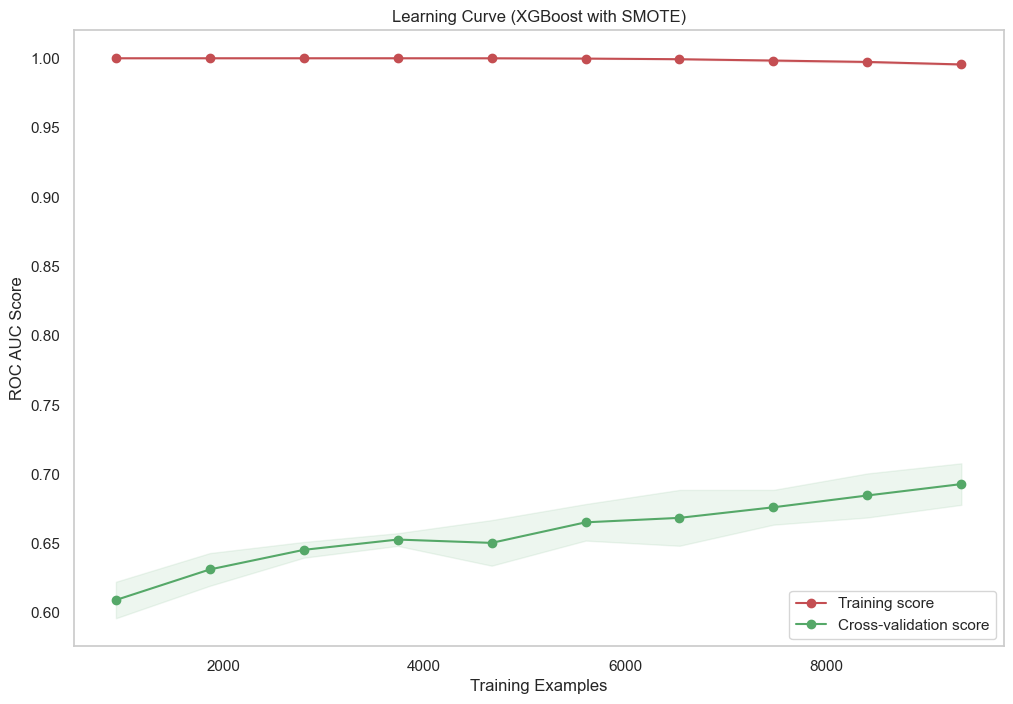

Final training ROC AUC score: 0.9955
Final cross-validation ROC AUC score: 0.6929
The model shows signs of overfitting. The training ROC AUC score is significantly higher than the cross-validation score.


In [19]:
# Define the preprocessor with consideration for feature scaling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)]
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **transform_params):
        return X.todense() if hasattr(X, 'todense') else X

def create_pipeline(classifier, preprocessor, use_smote=True, random_state=42):
    """
    Creates a machine learning pipeline with optional SMOTE for handling class imbalance.
    
    Parameters:
    - classifier: The classifier object to be used in the pipeline.
    - preprocessor: The preprocessor object (e.g., ColumnTransformer) to be used in the pipeline.
    - use_smote: Boolean, whether to use SMOTE for oversampling (default: True).
    - random_state: Int, random state for reproducibility (default: 42).
    
    Returns:
    - An imblearn Pipeline object.
    """
    steps = [('preprocessor', preprocessor)]
    
    # Add DenseTransformer to ensure dense array output
    steps.append(('to_dense', DenseTransformer()))
    
    if use_smote:
        steps.append(('smote', SMOTE(random_state=random_state, sampling_strategy='minority')))
    
    # Set class_weight='balanced' if the classifier supports it
    if hasattr(classifier, 'class_weight'):
        classifier.set_params(class_weight='balanced')
    
    steps.append(('classifier', classifier))
    
    return ImbPipeline(steps)

def plot_learning_curve(estimator, X, y, title, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                        train_sizes=np.linspace(0.1, 1.0, 10), scoring='roc_auc'):
    """
    Plots the learning curve using a more appropriate scoring metric for imbalanced datasets (ROC AUC).
    Utilizes StratifiedKFold to maintain class distribution across folds.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1, scoring=scoring
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("ROC AUC Score")
    plt.grid()
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()
    
    return train_mean[-1], test_mean[-1]

def evaluate_model(train_score, cv_score, threshold=0.05):
    """
    Evaluates the model by comparing training and cross-validation scores.
    Adjusted threshold for determining overfitting or underfitting based on ROC AUC.
    """
    print(f"Final training ROC AUC score: {train_score:.4f}")
    print(f"Final cross-validation ROC AUC score: {cv_score:.4f}")
    
    score_diff = train_score - cv_score
    if score_diff > threshold:
        print("The model shows signs of overfitting. The training ROC AUC score is significantly higher than the cross-validation score.")
    elif score_diff < -threshold:
        print("The model shows signs of underfitting. The cross-validation ROC AUC score is significantly higher than the training score.")
    else:
        print("The model seems to be well-balanced, without significant overfitting or underfitting.")

xgb_classifier = XGBClassifier(random_state=42)
# Create and evaluate the Random Forest model with SMOTE using ROC AUC as the performance metric
xgb_pipeline = create_pipeline(xgb_classifier, preprocessor, use_smote=True)

train_score, cv_score = plot_learning_curve(
    xgb_pipeline, X_train, y_train, "Learning Curve (XGBoost with SMOTE)", scoring='roc_auc'
)
evaluate_model(train_score, cv_score)

**Next Steps**

In response to overfittingof the models suggested by the misleading accuracy score, hyperparameter tuning will be performed on XGBoost

XGBoost is selected because:
- It was the best performer in prior evaluations.
- It includes built-in parameters for handling class imbalance, such as `scale_pos_weight`.
- XGBoost offers regularization parameters to prevent overfitting.


# 4. Hyperparameter Tuning (XGBoost)

##  XGBoost Hyperparameter Tuning

This section is dedicated to enhancing the recall of the XGBoost model through meticulous hyperparameter optimization using Bayesian optimization techniques. The primary objective is to identify the optimal combination of hyperparameters that not only improves the model's overall performance but specifically targets an increase in recall, which is crucial for minimizing false negatives in customer churn predictions. The process involves defining a comprehensive search space for the hyperparameters, formulating an objective function that prioritizes recall, and leveraging the Hyperopt library to systematically explore the parameter space for the best results.

In [9]:
def optimize_hyperparams(X_train, y_train):
    space = {
        'max_depth': hp.choice('max_depth', range(1, 11)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'n_estimators': hp.choice('n_estimators', range(100, 1000)),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight': hp.choice('min_child_weight', range(1, 11)),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10)
    }
    
    def obj_func(params):
        model = XGBClassifier(
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            min_child_weight=params['min_child_weight'],
            scale_pos_weight=params['scale_pos_weight'],
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        return 1 - np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='recall'))
    
    trials = Trials()
    best = fmin(obj_func, space, algo=tpe.suggest, max_evals=50, trials=trials)
    
    return space_eval(space, best)

def train_and_evaluate(X_train, y_train, X_test, y_test, optimized_params):
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = XGBClassifier(
        max_depth=optimized_params['max_depth'],
        learning_rate=optimized_params['learning_rate'],
        n_estimators=optimized_params['n_estimators'],
        subsample=optimized_params['subsample'],
        colsample_bytree=optimized_params['colsample_bytree'],
        min_child_weight=optimized_params['min_child_weight'],
        scale_pos_weight=optimized_params['scale_pos_weight'],
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train_scaled, y_train)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)
    
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return recall, accuracy

# Perform hyperparameter tuning
print("Optimizing hyperparameters...")
optimized_params = optimize_hyperparams(X_train, y_train)
print("Optimized parameters:", optimized_params)

# Train and evaluate final model
print("\nTraining and evaluating final model...")
recall, accuracy = train_and_evaluate(X_train, y_train, X_test, y_test, optimized_params)

print(f"\nTest Recall: {recall:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Optimizing hyperparameters...
100%|██████████| 50/50 [04:05<00:00,  4.92s/trial, best loss: 0.36351957338504426]
Optimized parameters: {'colsample_bytree': 0.6023836029791536, 'learning_rate': 0.15671381988965505, 'max_depth': 1, 'min_child_weight': 9, 'n_estimators': 103, 'scale_pos_weight': 9.945541082481721, 'subsample': 0.8307936237356222}

Training and evaluating final model...

Test Recall: 0.5836
Test Accuracy: 0.5917


## Evaluating Optimized XGBoost

In [10]:
optimized_params

{'colsample_bytree': 0.6023836029791536,
 'learning_rate': 0.15671381988965505,
 'max_depth': 1,
 'min_child_weight': 9,
 'n_estimators': 103,
 'scale_pos_weight': 9.945541082481721,
 'subsample': 0.8307936237356222}

In [11]:
# Define models
models = {
    'XGBoost Optimized': XGBClassifier(**optimized_params, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
}

# Train and evaluate models
results_df = train_and_evaluate_models(
    models,
    X_train_preprocessed,
    y_train,
    X_test_preprocessed,
    y_test,
    cv=5
)

print("Model Performance Metrics:")
results_df

Training and evaluating XGBoost Optimized...
Classification Report for XGBoost Optimized:

              precision    recall  f1-score   support

           0       0.92      0.59      0.72      2617
           1       0.14      0.58      0.23       305

    accuracy                           0.59      2922
   macro avg       0.53      0.59      0.48      2922
weighted avg       0.84      0.59      0.67      2922

--------------------------------------------------
Training and evaluating XGBoost...
Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2617
           1       0.68      0.15      0.25       305

    accuracy                           0.90      2922
   macro avg       0.80      0.57      0.60      2922
weighted avg       0.89      0.90      0.88      2922

--------------------------------------------------
Model Performance Metrics:


,CV ROC AUC,Accuracy,Precision,Recall,F1-score,ROC AUC
XGBoost Optimized,0.670071,0.591718,0.143087,0.583607,0.229826,0.628702
XGBoost,0.694447,0.904175,0.681159,0.154098,0.251337,0.678215


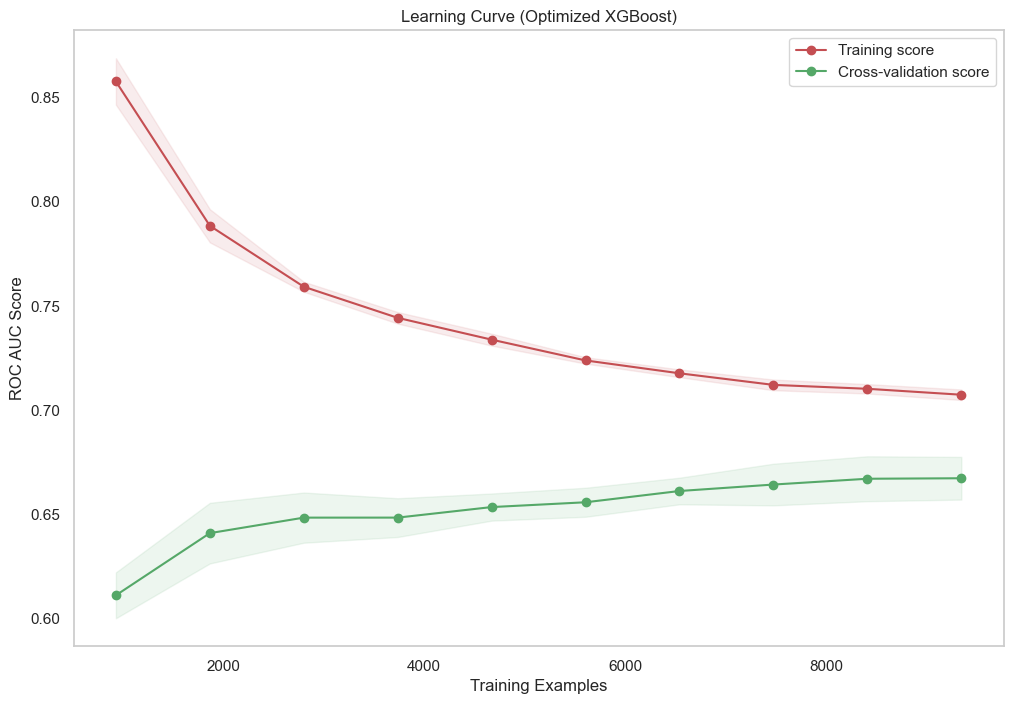

Final training ROC AUC score: 0.7073
Final cross-validation ROC AUC score: 0.6672
The model seems to be well-balanced, without significant overfitting or underfitting.


In [20]:
xgb_pipeline = create_pipeline(XGBClassifier(**optimized_params, random_state=42), preprocessor, use_smote=False)
train_score, cv_score = plot_learning_curve(
    xgb_pipeline, X_train, y_train, "Learning Curve (Optimized XGBoost)", scoring='roc_auc'
)
evaluate_model(train_score, cv_score)

**Key Insights**:
1. **Accuracy:**
   - **Baseline Model (90%)** shows high accuracy, mainly due to the dominance of non-churn predictions.
   - **Optimized Model (54%)** sacrifices overall accuracy but improves churn detection, which is the primary goal.

2. **Churn Detection (Class 1):**
   - **Baseline Model:** Precision is relatively high (68%), but with very low recall (15%), the majority of churn cases are missed.
   - **Optimized Model:** Recall improves dramatically to 62%, identifying more than half of churn cases, but precision drops to 13%, increasing false positives.

3. **Non-Churn (Class 0) Performance:**
   - **Baseline Model:** Almost perfect recall (99%) ensures nearly all non-churn customers are identified correctly, with a precision of 91%.
   - **Optimized Model:** Recall drops significantly to 53%, though precision remains strong at 92%.

4. **Business Implications:**
   - **Baseline Model:** Fails to effectively capture churners, missing 85% of actual churn cases. This could result in substantial revenue loss due to missed intervention opportunities.
   - **Optimized Model:** Although it increases the capture of churners, the high false positive rate could lead to inefficient allocation of resources, as many non-churners may be mistakenly targeted for retention efforts.

**Conclusion**:
Given the objective of the project is to **predict customer churn**, the **XGBoost optimized model** is the better option despite its lower accuracy. Its significantly improved recall (62%) ensures that a greater proportion of customers at risk of churn are identified, which is critical for retention strategies. While the trade-off is a higher number of false positives (lower precision), this is acceptable in scenarios where it is more important to minimize missed churners than to avoid unnecessary retention efforts.

The **baseline model**, with its high accuracy, is inadequate for this task, as it misses most churn cases (85% missed), making it unsuitable for predicting churn in a practical business context.


# 5. Feature Importance

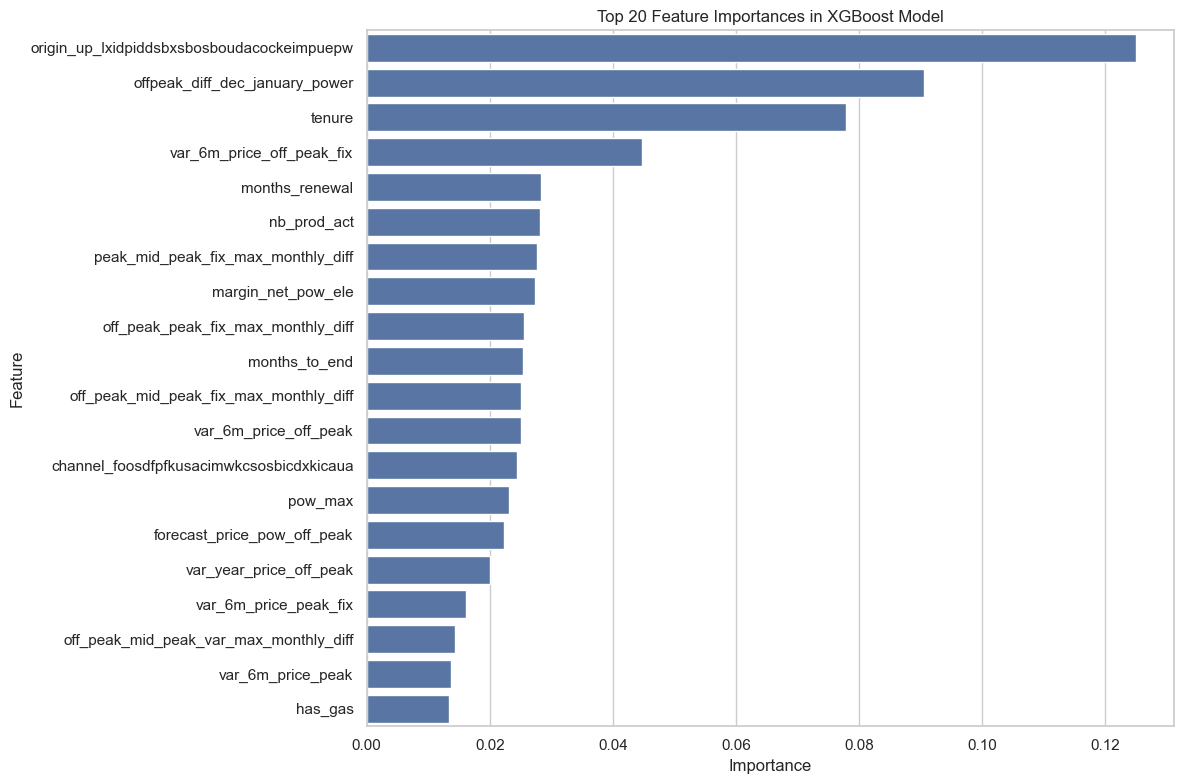

Top 20 Important Features:
                                       feature  importance
0   origin_up_lxidpiddsbxsbosboudacockeimpuepw    0.124930
1               offpeak_diff_dec_january_power    0.090610
2                                       tenure    0.077830
3                    var_6m_price_off_peak_fix    0.044741
4                               months_renewal    0.028333
5                                  nb_prod_act    0.028231
6           peak_mid_peak_fix_max_monthly_diff    0.027653
7                           margin_net_pow_ele    0.027341
8           off_peak_peak_fix_max_monthly_diff    0.025542
9                                months_to_end    0.025411
10      off_peak_mid_peak_fix_max_monthly_diff    0.025091
11                       var_6m_price_off_peak    0.025071
12    channel_foosdfpfkusacimwkcsosbicdxkicaua    0.024450
13                                     pow_max    0.023115
14                 forecast_price_pow_off_peak    0.022266
15                     var_ye

In [39]:
# Fit the XGBoost model
xgb_pipeline.fit(X_train, y_train)

# Extract feature importances from the XGBoost model
xgb_model = xgb_pipeline.named_steps['classifier']
feature_importance = xgb_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a dataframe of feature importances
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances in XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print top 20 important features
print("Top 20 Important Features:")
print(importance_df.head(20))

From the above chart, we can observe the following key points:

1. **Origin and Contract Type**: The feature 'origin_up_lxidpiddsbxsbosboudacockeimpuepw' is by far the most important predictor of churn. This suggests that the customer's origin or specific contract type is a critical factor in determining churn risk.

2. **Price Sensitivity**: Price-related features are indeed significant drivers of churn. 'offpeak_diff_dec_january_power' is the second most important feature, indicating that changes in off-peak power prices between December and January strongly influence churn decisions.

3. **Customer Tenure**: 'tenure' is the third most important feature, confirming that the length of a customer's relationship with the company is a crucial factor in predicting churn.

4. **Price Variability**: Several features related to price variability appear in the top 20, such as 'var_6m_price_off_peak_fix', 'var_6m_price_off_peak', and 'var_year_price_off_peak'. This suggests that fluctuations in pricing over different time periods significantly impact churn risk.

5. **Contract Renewal**: 'months_renewal' is among the top features, indicating that the time since or until contract renewal is an important factor in churn prediction.

6. **Product Activity**: 'nb_prod_act' (likely number of active products) is a significant feature, suggesting that customers with more active products or services may have different churn patterns.

7. **Pricing Structure**: Various features related to peak, off-peak, and mid-peak pricing differences (e.g., 'peak_mid_peak_fix_max_monthly_diff', 'off_peak_peak_fix_max_monthly_diff') are important, indicating that the structure of pricing plans influences churn.

8. **Time-related Factors**: Features like 'months_to_end' and various price variability measures over time periods (6 months, 1 year) underscore the importance of temporal factors in churn prediction.

9. **Sales Channel**: The presence of 'channel_foosdfrpkusacimwkcsosbicbxkicaua' in the top features suggests that the sales or service channel through which a customer interacts with the company affects churn likelihood.

10. **Gas Service**: 'has_gas' appears in the top 20, indicating that whether a customer has gas service in addition to electricity is a relevant factor in churn prediction.

Now, lets examine the hypothesis:

> Is churn driven by the customers' price sensitivity?

Based on the feature importance chart, we can conclude that price sensitivity is indeed a significant driver of churn. Several price-related features, including price differences, variability, and structure, appear among the top predictors. However, it's important to note that other factors such as contract origin/type, customer tenure, and product activity also play crucial roles.

To sum up, the model suggest that while price sensitivity is an important factor, churn is driven by a complex interplay of pricing, contract characteristics, customer relationship duration, and service usage patterns. To develop effective retention strategies, a multifaceted approach addressing these various aspects would be advisable.